In [ ]:
!pip list

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [31]:
 tf.config.list_physical_devices('GPU')

[]

In [7]:
physical_devices=tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [2]:
import gdown

In [8]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

NameError: name 'gdown' is not defined

In [3]:
def load_video(path:str) -> List[float]:
    
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame =tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [4]:
vocab=[x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [6]:
char_to_num(['n','i','c','k'])

NameError: name 'char_to_num' is not defined

In [7]:
num_to_char([14,9,3,11])

NameError: name 'num_to_char' is not defined

In [8]:
char_to_num=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()})"
     )

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path,'r') as f:
        lines=f.readlines()
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!='sil':
            tokens=[*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('\\')[-1].split('.')[0]
    video_path=os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
test_path='.\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [44]:
frames, alignments=load_data(tf.convert_to_tensor(test_path))

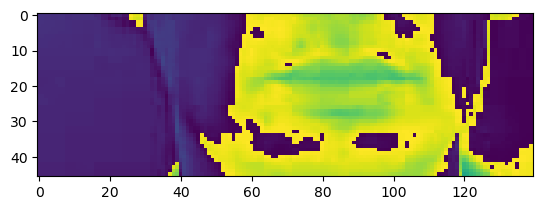

In [45]:
plt.imshow(frames[0])

In [46]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [47]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [12]:
def mappable_function(path:str) ->List[str]:
    result=tf.py_function(load_data, [path],(tf.float32,tf.int64))
    return result

2. DATA PIPELINE

In [13]:
    data=tf.data.Dataset.list_files('./data/s1/*.mpg')
    data=data.shuffle(500,reshuffle_each_iteration=False)
    data=data.map(mappable_function)
    data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
    data=data.prefetch(tf.data.AUTOTUNE)
    
    train=data.take(450)
    test=data.skip(450)

In [50]:
frames,alignments =data.as_numpy_iterator().next()

In [51]:
alignments

array([[12,  1, 25, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 18, 39,  6,
         9, 22,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39,  7,
        39, 20, 23, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [52]:
frames

array([[[[[ 1.7121812 ],
          [ 1.6714151 ],
          [ 1.5491164 ],
          ...,
          [ 0.24459732],
          [ 0.2038311 ],
          [ 0.2038311 ]],

         [[ 1.7529474 ],
          [ 1.6714151 ],
          [ 1.4675839 ],
          ...,
          [ 0.28536355],
          [ 0.2038311 ],
          [ 0.2038311 ]],

         [[ 1.4268177 ],
          [ 1.4268177 ],
          [ 1.4268177 ],
          ...,
          [ 0.24459732],
          [ 0.16306488],
          [ 0.16306488]],

         ...,

         [[ 1.0191555 ],
          [ 1.0191555 ],
          [ 0.97838926],
          ...,
          [10.35462   ],
          [10.35462   ],
          [10.35462   ]],

         [[ 1.0191555 ],
          [ 1.0191555 ],
          [ 0.97838926],
          ...,
          [10.313854  ],
          [10.313854  ],
          [10.313854  ]],

         [[ 1.0191555 ],
          [ 1.0191555 ],
          [ 0.97838926],
          ...,
          [10.313854  ],
          [10.313854  ],
          

In [53]:
len(frames)

2

In [14]:
test=data.as_numpy_iterator()

In [15]:
val=test.next(); val[0]

array([[[[[ 1.654154  ],
          [ 1.654154  ],
          [ 1.6138088 ],
          ...,
          [ 0.04034522],
          [ 0.08069044],
          [ 0.08069044]],

         [[ 1.654154  ],
          [ 1.654154  ],
          [ 1.6138088 ],
          ...,
          [ 0.04034522],
          [ 0.08069044],
          [ 0.08069044]],

         [[ 1.4120827 ],
          [ 1.4120827 ],
          [ 1.4120827 ],
          ...,
          [ 0.08069044],
          [ 0.08069044],
          [ 0.08069044]],

         ...,

         [[ 1.0086304 ],
          [ 1.0086304 ],
          [ 1.0086304 ],
          ...,
          [10.086305  ],
          [10.086305  ],
          [10.086305  ]],

         [[ 1.0086304 ],
          [ 1.0086304 ],
          [ 1.0086304 ],
          ...,
          [10.086305  ],
          [10.086305  ],
          [10.086305  ]],

         [[ 1.0086304 ],
          [ 1.0086304 ],
          [ 1.0086304 ],
          ...,
          [10.086305  ],
          [10.086305  ],
          

In [56]:
imageio.mimsave('./animation.gif',val[0][1],fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.941047668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

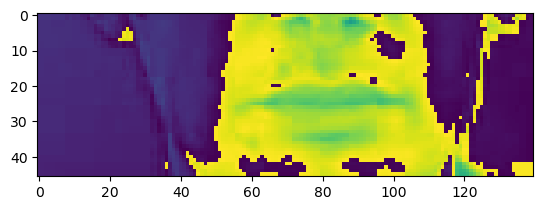

In [57]:
plt.imshow(val[0][0][0])

In [58]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at k zero now'>

3. design the deep neural network

In [16]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional,MaxPool3D,Activation,Reshape,SpatialDropout3D,BatchNormalization,TimeDistributed,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [17]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model=Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [27]:
yhat=model.predict(val[0])

NameError: name 'val' is not defined

In [44]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjjjjjjjjjjjjjjeeiiiiiiiiiiiiiiiiiiiiiijjjjjjjjjjjjjjjjjjeeeeeeeeeeeee'>

In [45]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,
        5,  5,  5,  5,  5,  9,  9], dtype=int64)>

 4.setup training options and train

In [36]:
def scheduler(epoch,lr):
    if epoch <30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [37]:
def CTCLoss(y_true,y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1],dtype="int64")
    
    input_length=input_length*tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype="int64")
    
    loss=tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss

In [38]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [39]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [40]:
schedule_callback = LearningRateScheduler(scheduler)

In [41]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(train ,validation_data=test,epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

5.Make a Prediction

In [32]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=a2e3e25b-ed04-4162-b625-1406f6958220
To: C:\Users\pavan\LipNet\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:12<00:00, 7.56MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [45]:
model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [46]:


test_data = test.as_numpy_iterator()



AttributeError: '_NumpyIterator' object has no attribute 'as_numpy_iterator'

In [47]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [48]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [49]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 4s 4s/step


In [50]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [51]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'!ou'>]